# Pipeline for Dog_App

This is the code that would be required to power a mobile or web app. It has been exported as a .py file also.

In [199]:
# import libraries
import cv2
from datetime import datetime
from extract_bottleneck_features import *
from glob import glob
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
from sklearn.datasets import load_files
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

In [200]:
def create_plot(pred_list, titles, img_list):
    """subplot all of the pictures with predictions and titles"""
    
    width = os.get_terminal_size().columns
    print('Dog Breed Predictions and What Breed Looks Like a Human'.center(width))
    
    # figure size
    fig = plt.figure(figsize=(16, 3 * len(pred_list)))
    
    # columns and rows of subplot
    columns = 2
    rows = len(pred_list)
    
    # build subplot
    for i in range(1, columns * rows + 1):
        
        plt.title(titles[i-1])
        img = img_list[i-1]
        fig.add_subplot(rows, columns, i)
        fig.tight_layout()
        plt.imshow(img)
            
    plt.title(titles[-1]) # print the last title on the last image
    plt.show();
    

In [201]:
def create_titles(pred_list, human_idx_list, human_files):
    """Create a title for each one of the pictures"""
    
    # First title set to ''. This is the main title and I don't like where matplotlib is putting it.
    titles = ['']
    
    for idx, pred in enumerate(pred_list):
        if pred[1] == 'dog':
            title = f'Predicted Dog: {pred[0]}'
            titles.append(title)
            titles.append('Its a Dog!')

        elif pred[1] == 'human':
            # Use modulo to get the right index
            idx_ = idx % n
            idx_ = human_idx_list[idx_]
            path = human_files[idx_]
            
            # It is also possible that one of the other images will trigger a face recognition
            # This is OK, but ... we do not want it to claim it is somebody in particular.
            common_title = f'Looks like a(n): {pred[0]}'
            if idx >= n and idx < n * 2:
                name = path.split('\\')[4]
                titles.append(name)
                titles.append(common_title)
            else:
                title = 'Algorithm Fooled:('
                titles.append(title)
                titles.append(common_title)

        elif pred[1] == 'other':
            title = 'Not a dog / human:('
            titles.append(title)
            title = 'Only pictures of dogs / humans!'
            titles.append(title)

        else:
            print('This should never happen!!')
                    
    return titles


In [202]:
def dog_detector(img_path):
    """returns "True" if a dog is detected in the image stored at img_path"""
    
    prediction = ResNet50_predict_labels(img_path)
    
    return ((prediction <= 268) & (prediction >= 151))


In [203]:
def face_detector(img_path):
    """returns "True" if face is detected in image stored at img_path"""
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0


In [204]:
def IV3_predict_breed(img_path):
    """Accepts an image path and returns a prediction as to the breed of the dog
    input: img_path(str) path for the image
    output: pred(str) breed prediction"""
    
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = IV3_model.predict(bottleneck_feature)
    
    # Get the prediction
    pred = dog_names[np.argmax(predicted_vector)]
    pred = pred.split('.')[1]
    
    # return dog breed that is predicted by the model
    return pred


In [205]:
def load_data_other(folder_path, n):
    """Takes a folder_path and does n random draws to return n number of file paths as an array"""

    other_img_ = []
    for times in range(n):
        for path in folder_path:

            # Get the files in the test folders
            files_in_folder = glob(path +  r'*.*')

            # Get a random file
            idx = random.randint(0, len(files_in_folder))
            img_path = files_in_folder[idx]

            # Append the files
            other_img_.append(img_path)
            
    return np.array(other_img_)


In [206]:
def load_dataset(path, nof_classes):
    """load train, test, or validation datasets"""
    
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), nof_classes)
    
    return dog_files, dog_targets


In [207]:
def path_to_tensor(img_path):
    """takes a string-valued file path to a color image as input and returns a 4D tensor 
    suitable for supplying to a Keras CNN."""
    
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)


In [208]:
def paths_to_tensor(img_paths):
    """takes a numpy array of string-valued image paths as input and returns a 4D tensor with 
    shape (nb_samples,224,224,3)."""
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    
    return np.vstack(list_of_tensors)


In [209]:
def predict_breed(img_path):
    """Accepts a file path to an image and first determines whether the image contains a human, dog, or neither. Then,
    if a dog is detected in the image, return the predicted breed.
    if a human is detected in the image, return the resembling dog breed.
    if neither is detected in the image, provide output that indicates an error.
    input: img_path(str) - The image path to the image of interest"""
    
    # Get the prediction
    pred = IV3_predict_breed(img_path)
    
    # Use the dog_detector function to detect whether or not there is a dog
    if dog_detector(img_path):
        return pred, 'dog'

    # Use the face_detector to detect a face
    elif face_detector(img_path):
        return pred, 'human'

    else:
        return pred, 'other'
    

In [210]:
def ResNet50_predict_labels(img_path):
    """returns prediction vector for image located at img_path"""
    
    img = preprocess_input(path_to_tensor(img_path))
    
    return np.argmax(ResNet50_model.predict(img))

In [211]:
def test_pics_preds(array, n):
    """Gets a random draw of n images from an array of file paths then return 3 lists"""
    
    # Get pictures
    img_list = []
    idx_list = []
    pred_list = []
    for num in range(n):
        
        # Get random picture
        idx = random.randint(0, array.shape[0] - 1)
        img_path = array[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_list.append(img)
        
        # Get the prediction
        pred, type_ = predict_breed(img_path)
        
        if type_ == 'dog':
            img_list.append(dog_png)
            pred_list.append((pred, type_))
            
        elif type_ == 'human':
            img_list.append(breed_img_dict[pred])
            pred_list.append((pred, type_))
            
        elif type_ == 'other':
            img_list.append(question_png)
            pred_list.append((np.nan, 'other'))
        
        else:
            print('This should never happen!', pred, type_)
        
        idx_list.append(idx)
         
    return img_list, idx_list, pred_list


In [212]:
def driver():
    """driver function that gets the data in, starts calling for the predictions and 
    finally shows the images and the predictions"""

    # get the dog test_files and predict
    test_files, test_targets = load_dataset(path_dogs + r'\test', nof_classes)
    dog_img_list, dog_idx_list, dog_pred_list = test_pics_preds(test_files, n)
    
    # get the human files and predict
    human_files = np.array(glob(path_humans + r"/lfw/*/*"))
    random.shuffle(human_files)
    human_img_list, human_idx_list, human_pred_list = test_pics_preds(human_files, n)
    
    # get the other files and predict
    other_img_ = load_data_other(folder_path, n)
    other_img_list, other_idx_list, other_pred_list = test_pics_preds(other_img_, n)
    
    # Build imgage, index and pred lists
    img_list = dog_img_list + human_img_list + other_img_list
    pred_list = dog_pred_list + human_pred_list + other_pred_list
    
    # Get titles
    titles = create_titles(pred_list, human_idx_list, human_files)

    # create plot
    create_plot(pred_list, titles, img_list)
    

In [228]:
# global

# number of photos per class (dog, human, other). 
# Must be between 1 and 5
n = 3

# load saved inceptionv3 model
IV3_model = load_model('saved_models/IV3_model.h5')

# load resnet weights
ResNet50_model = ResNet50(weights='imagenet')

# get breed image dictionary
with open(r'data\breed_img_dict.p', 'rb') as handle:
    breed_img_dict = pickle.load(handle)

# File paths
path_dogs = r'D:\large_files\DSND_Capstone\data\dog_images'
path_humans = r'D:\large_files\DSND_Capstone\data'
folder_path = glob(r'C:\Users\Lindsay\AI_P6\photos\test\*\\')

# actual dog name file paths
dog_names = [item[20:-1] for item in sorted(glob(path_dogs + r"/train/*/"))]
nof_classes = len(dog_names)

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Do not need to do this every time, so just do it once here.
dog_png = cv2.imread(r'images\dog.png')
dog_png = cv2.cvtColor(dog_png, cv2.COLOR_BGR2RGB)
question_png = cv2.imread(r'images\question.png')
question_png = cv2.cvtColor(question_png, cv2.COLOR_BGR2RGB)

                                Dog Breed Predictions and What Breed Looks Like a Human                                 


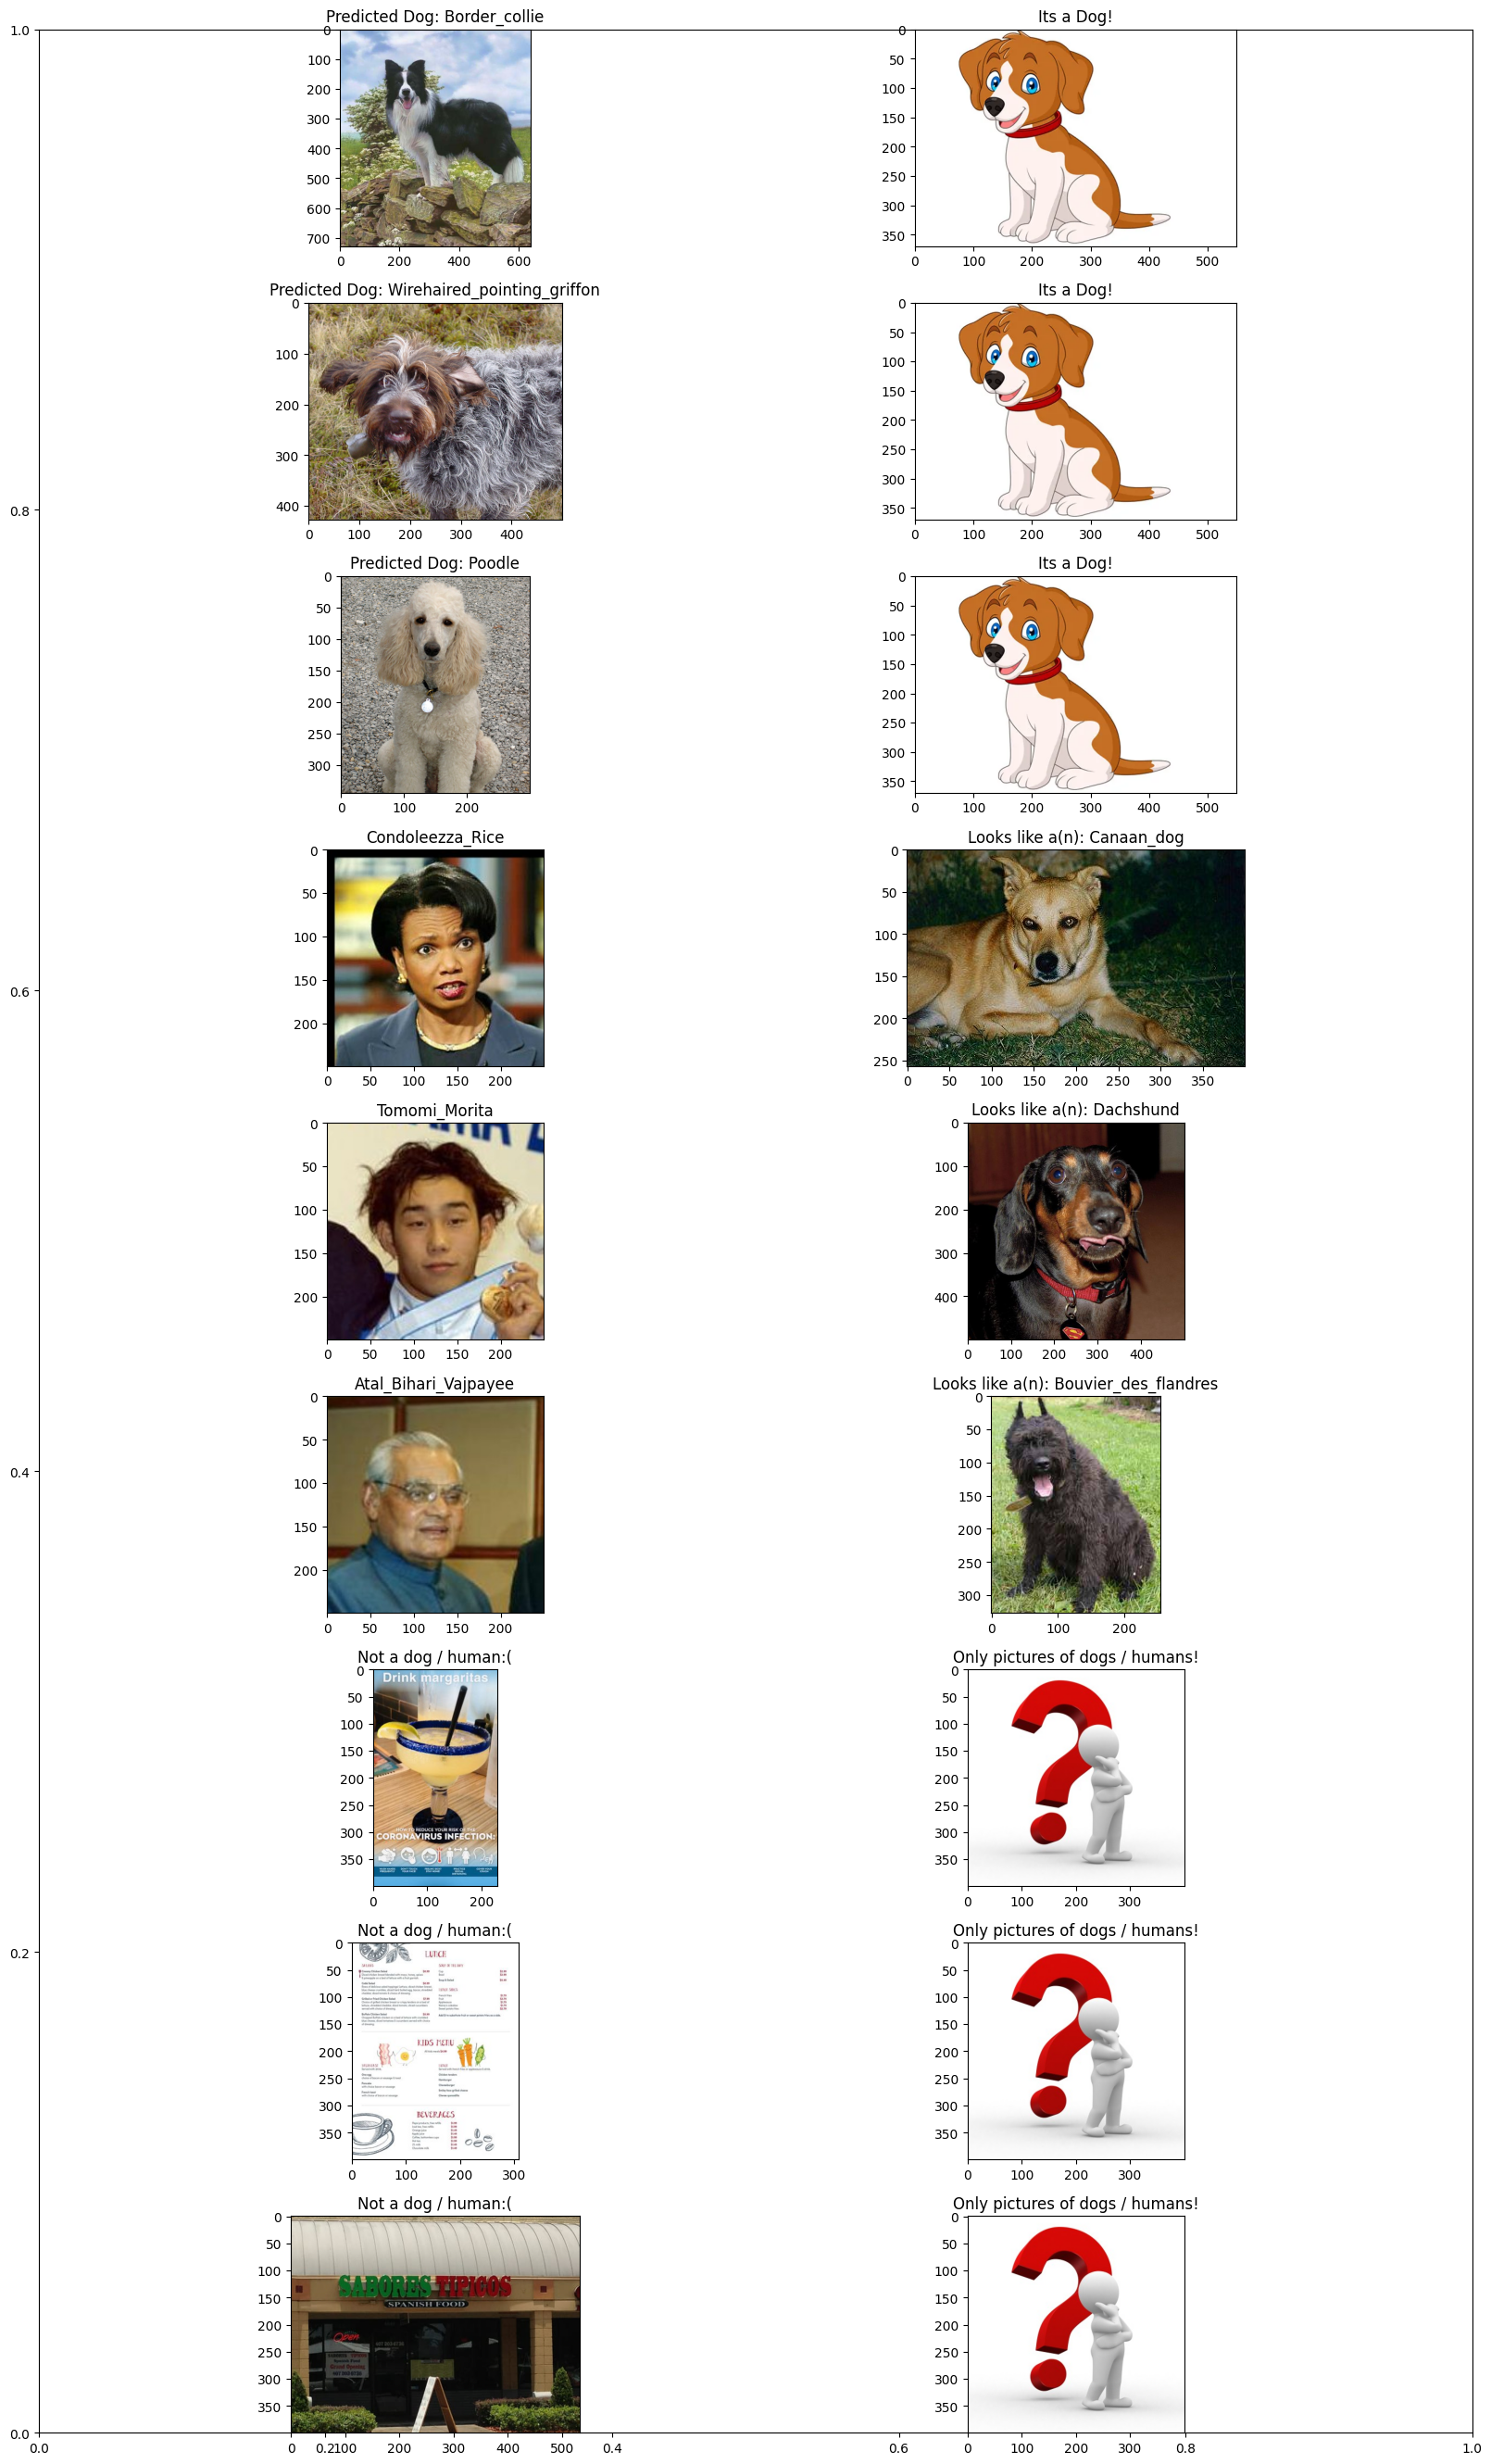

Prediction completed in time:  0:00:46.294794


In [229]:
start = datetime.now()

# if main
if __name__ == '__main__':
    driver()
    
    duration = datetime.now() - start
    print("Prediction completed in time: ", duration)